### Connect Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Put your path below

In [2]:
!cd '/content/drive/MyDrive/AIISC-Internship/text-based-object-discovery'

In [3]:
PATH = '/content/drive/MyDrive/AIISC-Internship/text-based-object-discovery'

### Install Required Packages

`Stanza`, Stanford NLP Package benefits from `GPU` so enable it under `View Resources > Change runtime type`

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ea4cf3b3-9f34-0aff-d6a6-1c814b85a0a3)


In [ ]:
!pip install stanza # for stanford pos tagger
!pip install ftfy regex tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Load Necessary Libraries

We will load the necessary libraries required for generating DAAM outputs for input prompts.

In [4]:
import os
import json
from tqdm import tqdm

from matplotlib import pyplot as plt
import numpy as np

from nltk.corpus import stopwords

from pycocotools.coco import COCO

Download the stopwords for removing stopwords

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
import stanza
stanza.download('en')

INFO:stanza:Downloading default packages for language: en (English) ...
INFO:stanza:File exists: /root/stanza_resources/en/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources.


### Load Data

Below, we load the `MS-COCO` annotations to extract the captions to continue further with extracting the objects from each caption.

In [ ]:
!wget -c http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip
!rm annotations_trainval2017.zip
!ls annotations

--2023-01-03 10:15:37--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.128.35, 54.231.197.65, 52.216.50.105, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.128.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  16.0MB/s    in 10s     

2023-01-03 10:15:48 (23.5 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  annotations_trainval2017.zip
replace annotations/instances_train2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: captions_train2017.json   instances_val2017.json
captions_val2017.json	  person_keypoints_train2017.json
instances_train2017.json  person_keypoints_val2017.json


Now, we load the json file for the train and validation set captions.

In [ ]:
with open('annotations/captions_train2017.json') as json_file:
  caption_data_train_file = json.load(json_file)
with open('annotations/captions_val2017.json') as json_file:
  caption_data_val_file = json.load(json_file)

In [ ]:
caption_data_train = caption_data_train_file['annotations']
caption_data_val = caption_data_val_file['annotations']

In [ ]:
prompts_train = [ann['caption'] for ann in caption_data_train]
prompts_val = [ann['caption'] for ann in caption_data_val]

In [ ]:
print('***train captions***\n', '\n'.join(prompts_train[:5]))
print()
print('Number of train captions:', len(prompts_train))
print()
print()
print('***validation captions:***\n', '\n'.join(prompts_val[:5]))
print()
print('Number of train captions:', len(prompts_val))

***train captions***
 A bicycle replica with a clock as the front wheel.
A room with blue walls and a white sink and door.
A car that seems to be parked illegally behind a legally parked car
A large passenger airplane flying through the air.
There is a GOL plane taking off in a partly cloudy sky.

Number of train captions: 591753


***validation captions:***
 A black Honda motorcycle parked in front of a garage.
A Honda motorcycle parked in a grass driveway
An office cubicle with four different types of computers.
A small closed toilet in a cramped space.
Two women waiting at a bench next to a street.

Number of train captions: 25014


Cleaning the prompts. I adopt few ways to clean the prompt:
- Tokenization
- Remove stop words
- Remove non-alphabets
- Keep only nouns
- Lemmatization (to store the object name)

In [ ]:
# loads the text processing pipeline
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma')

# treebank-specific POS (XPOS) tags to keep, other POS tagged tokens will not be retained
keep_pos_tags = ['NN', 'NNS', 'NNP', 'NNPS']

# Stopwords
stpwords = set(stopwords.words('english'))

# extract parts of speech
def extract_pos(doc):
  parsed_text = list()
  for sent in doc.sentences:
    for wrd in sent.words:
      parsed_text.append((wrd.text, wrd.xpos))
  return parsed_text

# extract lemma
def extract_lemma(doc):
  parsed_text = list()
  for sent in doc.sentences:
    for wrd in sent.words:
      # extract text and lemma
      parsed_text.append((wrd.text, wrd.lemma))
  # return a dataframe
  return parsed_text

def clean_prompt(prompt):
  # tokenizes, lemmatizes and pos tags the prompt
  processed_prompt = nlp(prompt.lower())
  
  # extracts pos tags from the processed_prompt
  pos_tagged_prompt = extract_pos(processed_prompt)

  # lemmatized text
  lemmatized_prompt = extract_lemma(processed_prompt)

  # keep only the noun words, removes stopwords
  fin_prompt = [word for word, pos_tag in pos_tagged_prompt if ((pos_tag in keep_pos_tags) and (word not in stpwords))]
  obj_prompt = [word_lemma[1] for word_pos, word_lemma in zip(pos_tagged_prompt, lemmatized_prompt) if ((word_pos[1] in keep_pos_tags) and (word_lemma[0] not in stpwords))]
  return fin_prompt, obj_prompt

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |

INFO:stanza:Use device: gpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


An example is shown below for the application of `clean_prompt`.

In [ ]:
clean_prompt("The fishes are playing in the mountains.")

(['fishes', 'mountains'], ['fish', 'mountain'])

Below, we start processing each prompt and store the objects detected in the captions from train and validation split.

In [8]:
NUM_PROMPTS_INFO_DISPLAY = 500 # After processing how many prompts, some necessary information must be displayed
SAVE_AFTER = 10000 # Save after how many prompts processed

In [ ]:
import shutil # Removes directory if already present! CAREFUL!!!!!!!!!!!!!!!!!!
if os.path.exists(os.path.join(PATH, 'Caption-Processing')):
  shutil.rmtree(os.path.join(PATH, 'Caption-Processing'))
os.mkdir(os.path.join(PATH, 'Caption-Processing'))

In [ ]:
try:

  total_objects = set() # Stores the total number of distinct objects detected
  num_objects_detected = list() # Stores number of objects detected after processing some number of prompts iteratively

  print('Starting...')
  print('Captions to be processed:', len(prompts_train))
  print('Cleaning Prompts... Storing Objects per prompt...')

  # Processing each prompt and updating annotation file for train set
  for idx, prompt in tqdm(enumerate(prompts_train)):
    cleaned, objects = clean_prompt(prompt) # Process prompt
    # update files and object list
    caption_data_train_file['annotations'][idx]['cleaned'] = cleaned
    caption_data_train_file['annotations'][idx]['objects'] = objects
    total_objects.update(set(objects))

    if (idx+1) % NUM_PROMPTS_INFO_DISPLAY == 0: # Display Info
      print()
      print()
      print('***INFO***')
      print('Number of prompts processed:', (idx+1))
      print('Number of Unique objects detected so far:', len(total_objects))
      num_objects_detected.append(len(total_objects))

    if (idx+1) % SAVE_AFTER == 0: # Save Results in json
      with open(os.path.join(PATH, 'Caption-Processing/train-captions-processed.json'), 'w') as outfile:
        outfile.write(json.dumps({'captions': caption_data_train_file['annotations'], 'num_objects': num_objects_detected}, indent=4))
        print('Saved.. Intermediate Results in train-captions-processed.json')

  # Display info once the for loop ends
  if (idx-1) % NUM_PROMPTS_INFO_DISPLAY != 0: 
    print()
    print('***INFO***')
    print('Number of prompts processed:', (idx+1))
    print('Number of Unique objects detected so far:', len(total_objects))
    num_objects_detected.append(len(total_objects))

  # Save the processed captions data
  with open(os.path.join(PATH, 'Caption-Processing/train-captions-processed.json'), 'w') as outfile: # Save Results in json
    outfile.write(json.dumps({'captions': caption_data_train_file['annotations'], 'num_objects': num_objects_detected}, indent=4))

  # Save the objects detected info
  with open(os.path.join(PATH, 'Caption-Processing/train-objects.json'), 'w') as outfile: # Saving Total objects in json
    outfile.write(json.dumps({'objects': list(total_objects), 'num_objects': num_objects_detected}, indent=4))

  print('Saved and Finished Processing...')

except KeyboardInterrupt: # If keyboard interrupt then save whatever results you have obtained
  print('Stopped Abruptly.. Saving.. Saved..')
  with open(os.path.join(PATH, 'Caption-Processing/train-captions-processed.json'), 'w') as outfile: # Save Results in json
    outfile.write(json.dumps({'captions': caption_data_train_file['annotations'], 'num_objects': num_objects_detected}, indent=4))

  with open(os.path.join(PATH, 'Caption-Processing/train-objects.json'), 'w') as outfile: # Saving Total objects in json
    outfile.write(json.dumps({'objects': list(total_objects), 'num_objects': num_objects_detected}, indent=4))

Starting...
Captions to be processed: 591753
Cleaning Prompts... Storing Objects per prompt...


503it [00:19, 24.31it/s]



***INFO***
Number of prompts processed: 500
Number of Unique objects detected so far: 507


1005it [00:39, 26.66it/s]



***INFO***
Number of prompts processed: 1000
Number of Unique objects detected so far: 767


1505it [00:58, 25.44it/s]



***INFO***
Number of prompts processed: 1500
Number of Unique objects detected so far: 961


2004it [01:17, 25.48it/s]



***INFO***
Number of prompts processed: 2000
Number of Unique objects detected so far: 1129


2504it [01:37, 26.05it/s]



***INFO***
Number of prompts processed: 2500
Number of Unique objects detected so far: 1279


3005it [01:56, 26.93it/s]



***INFO***
Number of prompts processed: 3000
Number of Unique objects detected so far: 1396


3504it [02:15, 25.24it/s]



***INFO***
Number of prompts processed: 3500
Number of Unique objects detected so far: 1496


4003it [02:35, 20.67it/s]



***INFO***
Number of prompts processed: 4000
Number of Unique objects detected so far: 1601


4502it [02:54, 25.09it/s]



***INFO***
Number of prompts processed: 4500
Number of Unique objects detected so far: 1694


5003it [03:13, 26.36it/s]



***INFO***
Number of prompts processed: 5000
Number of Unique objects detected so far: 1771


5503it [03:32, 27.66it/s]



***INFO***
Number of prompts processed: 5500
Number of Unique objects detected so far: 1855


6003it [03:50, 26.82it/s]



***INFO***
Number of prompts processed: 6000
Number of Unique objects detected so far: 1926


6503it [04:09, 25.28it/s]



***INFO***
Number of prompts processed: 6500
Number of Unique objects detected so far: 2001


7004it [04:28, 26.02it/s]



***INFO***
Number of prompts processed: 7000
Number of Unique objects detected so far: 2067


7503it [04:46, 25.91it/s]



***INFO***
Number of prompts processed: 7500
Number of Unique objects detected so far: 2116


8005it [05:05, 27.07it/s]



***INFO***
Number of prompts processed: 8000
Number of Unique objects detected so far: 2167


8504it [05:24, 28.66it/s]



***INFO***
Number of prompts processed: 8500
Number of Unique objects detected so far: 2225


9003it [05:44, 26.30it/s]



***INFO***
Number of prompts processed: 9000
Number of Unique objects detected so far: 2295


9504it [06:02, 25.68it/s]



***INFO***
Number of prompts processed: 9500
Number of Unique objects detected so far: 2360


9999it [06:21, 26.66it/s]



***INFO***
Number of prompts processed: 10000
Number of Unique objects detected so far: 2414


10005it [06:25,  3.58it/s]

Saved.. Intermediate Results in train-captions-processed.json


10503it [06:44, 27.86it/s]



***INFO***
Number of prompts processed: 10500
Number of Unique objects detected so far: 2466


11002it [07:02, 25.88it/s]



***INFO***
Number of prompts processed: 11000
Number of Unique objects detected so far: 2524


11503it [07:21, 27.46it/s]



***INFO***
Number of prompts processed: 11500
Number of Unique objects detected so far: 2559


12003it [07:40, 24.49it/s]



***INFO***
Number of prompts processed: 12000
Number of Unique objects detected so far: 2599


12503it [07:59, 24.45it/s]



***INFO***
Number of prompts processed: 12500
Number of Unique objects detected so far: 2633


13004it [08:17, 27.56it/s]



***INFO***
Number of prompts processed: 13000
Number of Unique objects detected so far: 2660


13504it [08:37, 26.68it/s]



***INFO***
Number of prompts processed: 13500
Number of Unique objects detected so far: 2688


14005it [08:56, 27.22it/s]



***INFO***
Number of prompts processed: 14000
Number of Unique objects detected so far: 2736


14503it [09:15, 26.25it/s]



***INFO***
Number of prompts processed: 14500
Number of Unique objects detected so far: 2772


15002it [09:33, 26.19it/s]



***INFO***
Number of prompts processed: 15000
Number of Unique objects detected so far: 2801


15504it [09:52, 26.08it/s]



***INFO***
Number of prompts processed: 15500
Number of Unique objects detected so far: 2848


16004it [10:11, 26.99it/s]



***INFO***
Number of prompts processed: 16000
Number of Unique objects detected so far: 2877


16505it [10:29, 25.59it/s]



***INFO***
Number of prompts processed: 16500
Number of Unique objects detected so far: 2916


17004it [10:48, 25.75it/s]



***INFO***
Number of prompts processed: 17000
Number of Unique objects detected so far: 2953


17503it [11:07, 25.99it/s]



***INFO***
Number of prompts processed: 17500
Number of Unique objects detected so far: 2990


18004it [11:26, 25.28it/s]



***INFO***
Number of prompts processed: 18000
Number of Unique objects detected so far: 3020


18502it [11:45, 26.75it/s]



***INFO***
Number of prompts processed: 18500
Number of Unique objects detected so far: 3047


19004it [12:03, 26.51it/s]



***INFO***
Number of prompts processed: 19000
Number of Unique objects detected so far: 3079


19505it [12:22, 27.11it/s]



***INFO***
Number of prompts processed: 19500
Number of Unique objects detected so far: 3099


19999it [12:40, 28.74it/s]



***INFO***
Number of prompts processed: 20000
Number of Unique objects detected so far: 3125


20002it [12:43,  2.55it/s]

Saved.. Intermediate Results in train-captions-processed.json


20503it [13:02, 27.99it/s]



***INFO***
Number of prompts processed: 20500
Number of Unique objects detected so far: 3159


21004it [13:21, 26.69it/s]



***INFO***
Number of prompts processed: 21000
Number of Unique objects detected so far: 3194


21505it [13:39, 27.91it/s]



***INFO***
Number of prompts processed: 21500
Number of Unique objects detected so far: 3244


22005it [13:58, 27.62it/s]



***INFO***
Number of prompts processed: 22000
Number of Unique objects detected so far: 3278


22503it [14:17, 26.78it/s]



***INFO***
Number of prompts processed: 22500
Number of Unique objects detected so far: 3306


23003it [14:36, 28.85it/s]



***INFO***
Number of prompts processed: 23000
Number of Unique objects detected so far: 3332


23504it [14:55, 26.53it/s]



***INFO***
Number of prompts processed: 23500
Number of Unique objects detected so far: 3363


24005it [15:13, 27.23it/s]



***INFO***
Number of prompts processed: 24000
Number of Unique objects detected so far: 3391


24504it [15:31, 26.93it/s]



***INFO***
Number of prompts processed: 24500
Number of Unique objects detected so far: 3417


25004it [15:50, 26.14it/s]



***INFO***
Number of prompts processed: 25000
Number of Unique objects detected so far: 3445


25503it [16:09, 26.21it/s]



***INFO***
Number of prompts processed: 25500
Number of Unique objects detected so far: 3475


26005it [16:27, 29.07it/s]



***INFO***
Number of prompts processed: 26000
Number of Unique objects detected so far: 3507


26505it [16:46, 27.40it/s]



***INFO***
Number of prompts processed: 26500
Number of Unique objects detected so far: 3525


27004it [17:04, 26.57it/s]



***INFO***
Number of prompts processed: 27000
Number of Unique objects detected so far: 3547


27503it [17:24, 25.84it/s]



***INFO***
Number of prompts processed: 27500
Number of Unique objects detected so far: 3581


28005it [17:43, 25.58it/s]



***INFO***
Number of prompts processed: 28000
Number of Unique objects detected so far: 3614


28504it [18:01, 27.60it/s]



***INFO***
Number of prompts processed: 28500
Number of Unique objects detected so far: 3636


29003it [18:20, 26.82it/s]



***INFO***
Number of prompts processed: 29000
Number of Unique objects detected so far: 3670


29505it [18:39, 27.69it/s]



***INFO***
Number of prompts processed: 29500
Number of Unique objects detected so far: 3714


29997it [18:57, 26.74it/s]



***INFO***
Number of prompts processed: 30000
Number of Unique objects detected so far: 3761


30002it [19:01,  3.28it/s]

Saved.. Intermediate Results in train-captions-processed.json


30503it [19:20, 26.46it/s]



***INFO***
Number of prompts processed: 30500
Number of Unique objects detected so far: 3803


31005it [19:39, 24.90it/s]



***INFO***
Number of prompts processed: 31000
Number of Unique objects detected so far: 3850


31504it [19:58, 26.07it/s]



***INFO***
Number of prompts processed: 31500
Number of Unique objects detected so far: 3896


32004it [20:18, 23.81it/s]



***INFO***
Number of prompts processed: 32000
Number of Unique objects detected so far: 3930


32503it [20:37, 24.01it/s]



***INFO***
Number of prompts processed: 32500
Number of Unique objects detected so far: 3986


33005it [20:55, 27.43it/s]



***INFO***
Number of prompts processed: 33000
Number of Unique objects detected so far: 4009


33503it [21:13, 27.51it/s]



***INFO***
Number of prompts processed: 33500
Number of Unique objects detected so far: 4048


34003it [21:31, 28.53it/s]



***INFO***
Number of prompts processed: 34000
Number of Unique objects detected so far: 4078


34506it [21:49, 26.72it/s]



***INFO***
Number of prompts processed: 34500
Number of Unique objects detected so far: 4113


35002it [22:08, 26.43it/s]



***INFO***
Number of prompts processed: 35000
Number of Unique objects detected so far: 4154


35503it [22:26, 24.76it/s]



***INFO***
Number of prompts processed: 35500
Number of Unique objects detected so far: 4184


36005it [22:44, 29.50it/s]



***INFO***
Number of prompts processed: 36000
Number of Unique objects detected so far: 4207


36503it [23:03, 27.33it/s]



***INFO***
Number of prompts processed: 36500
Number of Unique objects detected so far: 4233


37003it [23:22, 25.86it/s]



***INFO***
Number of prompts processed: 37000
Number of Unique objects detected so far: 4271


37503it [23:41, 26.91it/s]



***INFO***
Number of prompts processed: 37500
Number of Unique objects detected so far: 4304


38003it [24:00, 27.04it/s]



***INFO***
Number of prompts processed: 38000
Number of Unique objects detected so far: 4332


38504it [24:18, 28.02it/s]



***INFO***
Number of prompts processed: 38500
Number of Unique objects detected so far: 4360


39003it [24:37, 26.87it/s]



***INFO***
Number of prompts processed: 39000
Number of Unique objects detected so far: 4389


39505it [24:55, 26.56it/s]



***INFO***
Number of prompts processed: 39500
Number of Unique objects detected so far: 4404


39997it [25:13, 27.38it/s]



***INFO***
Number of prompts processed: 40000
Number of Unique objects detected so far: 4439


40002it [25:17,  3.15it/s]

Saved.. Intermediate Results in train-captions-processed.json


40503it [25:35, 27.99it/s]



***INFO***
Number of prompts processed: 40500
Number of Unique objects detected so far: 4460


41003it [25:54, 25.12it/s]



***INFO***
Number of prompts processed: 41000
Number of Unique objects detected so far: 4483


41505it [26:14, 27.04it/s]



***INFO***
Number of prompts processed: 41500
Number of Unique objects detected so far: 4511


42003it [26:32, 27.45it/s]



***INFO***
Number of prompts processed: 42000
Number of Unique objects detected so far: 4543


42504it [26:50, 28.05it/s]



***INFO***
Number of prompts processed: 42500
Number of Unique objects detected so far: 4564


43004it [27:09, 27.43it/s]



***INFO***
Number of prompts processed: 43000
Number of Unique objects detected so far: 4587


43504it [27:27, 28.21it/s]



***INFO***
Number of prompts processed: 43500
Number of Unique objects detected so far: 4611


44005it [27:45, 29.49it/s]



***INFO***
Number of prompts processed: 44000
Number of Unique objects detected so far: 4634


44504it [28:02, 29.01it/s]



***INFO***
Number of prompts processed: 44500
Number of Unique objects detected so far: 4664


45005it [28:21, 26.70it/s]



***INFO***
Number of prompts processed: 45000
Number of Unique objects detected so far: 4691


45506it [28:39, 27.99it/s]



***INFO***
Number of prompts processed: 45500
Number of Unique objects detected so far: 4715


46004it [28:57, 27.96it/s]



***INFO***
Number of prompts processed: 46000
Number of Unique objects detected so far: 4734


46504it [29:16, 27.33it/s]



***INFO***
Number of prompts processed: 46500
Number of Unique objects detected so far: 4754


47005it [29:35, 27.78it/s]



***INFO***
Number of prompts processed: 47000
Number of Unique objects detected so far: 4777


47505it [29:53, 27.86it/s]



***INFO***
Number of prompts processed: 47500
Number of Unique objects detected so far: 4807


48005it [30:11, 28.87it/s]



***INFO***
Number of prompts processed: 48000
Number of Unique objects detected so far: 4826


48504it [30:29, 26.20it/s]



***INFO***
Number of prompts processed: 48500
Number of Unique objects detected so far: 4839


49003it [30:47, 25.99it/s]



***INFO***
Number of prompts processed: 49000
Number of Unique objects detected so far: 4863


49504it [31:05, 25.98it/s]



***INFO***
Number of prompts processed: 49500
Number of Unique objects detected so far: 4878


49998it [31:23, 25.61it/s]



***INFO***
Number of prompts processed: 50000
Number of Unique objects detected so far: 4909


50004it [31:27,  3.38it/s]

Saved.. Intermediate Results in train-captions-processed.json


50503it [31:46, 26.59it/s]



***INFO***
Number of prompts processed: 50500
Number of Unique objects detected so far: 4940


51003it [32:05, 26.72it/s]



***INFO***
Number of prompts processed: 51000
Number of Unique objects detected so far: 4954


51504it [32:23, 25.48it/s]



***INFO***
Number of prompts processed: 51500
Number of Unique objects detected so far: 4973


52005it [32:41, 29.24it/s]



***INFO***
Number of prompts processed: 52000
Number of Unique objects detected so far: 4994


52504it [32:59, 27.99it/s]



***INFO***
Number of prompts processed: 52500
Number of Unique objects detected so far: 5013


53005it [33:17, 26.49it/s]



***INFO***
Number of prompts processed: 53000
Number of Unique objects detected so far: 5045


53503it [33:35, 26.74it/s]



***INFO***
Number of prompts processed: 53500
Number of Unique objects detected so far: 5066


54004it [33:54, 27.98it/s]



***INFO***
Number of prompts processed: 54000
Number of Unique objects detected so far: 5082


54502it [34:12, 25.33it/s]



***INFO***
Number of prompts processed: 54500
Number of Unique objects detected so far: 5098


55005it [34:30, 29.60it/s]



***INFO***
Number of prompts processed: 55000
Number of Unique objects detected so far: 5126


55505it [34:48, 27.79it/s]



***INFO***
Number of prompts processed: 55500
Number of Unique objects detected so far: 5154


56005it [35:07, 28.38it/s]



***INFO***
Number of prompts processed: 56000
Number of Unique objects detected so far: 5189


56504it [35:26, 28.96it/s]



***INFO***
Number of prompts processed: 56500
Number of Unique objects detected so far: 5220


57005it [35:44, 26.34it/s]



***INFO***
Number of prompts processed: 57000
Number of Unique objects detected so far: 5241


57504it [36:02, 26.26it/s]



***INFO***
Number of prompts processed: 57500
Number of Unique objects detected so far: 5262


58005it [36:20, 26.84it/s]



***INFO***
Number of prompts processed: 58000
Number of Unique objects detected so far: 5282


58505it [36:39, 27.53it/s]



***INFO***
Number of prompts processed: 58500
Number of Unique objects detected so far: 5310


59005it [36:57, 27.61it/s]



***INFO***
Number of prompts processed: 59000
Number of Unique objects detected so far: 5336


59505it [37:16, 27.01it/s]



***INFO***
Number of prompts processed: 59500
Number of Unique objects detected so far: 5355


59998it [37:34, 27.30it/s]



***INFO***
Number of prompts processed: 60000
Number of Unique objects detected so far: 5384


60004it [37:38,  3.20it/s]

Saved.. Intermediate Results in train-captions-processed.json


60505it [37:59, 26.06it/s]



***INFO***
Number of prompts processed: 60500
Number of Unique objects detected so far: 5404


61004it [38:17, 28.94it/s]



***INFO***
Number of prompts processed: 61000
Number of Unique objects detected so far: 5438


61505it [38:35, 26.63it/s]



***INFO***
Number of prompts processed: 61500
Number of Unique objects detected so far: 5464


62003it [38:53, 29.04it/s]



***INFO***
Number of prompts processed: 62000
Number of Unique objects detected so far: 5486


62503it [39:12, 27.71it/s]



***INFO***
Number of prompts processed: 62500
Number of Unique objects detected so far: 5511


63003it [39:31, 25.89it/s]



***INFO***
Number of prompts processed: 63000
Number of Unique objects detected so far: 5540


63505it [39:49, 26.46it/s]



***INFO***
Number of prompts processed: 63500
Number of Unique objects detected so far: 5560


64003it [40:08, 27.53it/s]



***INFO***
Number of prompts processed: 64000
Number of Unique objects detected so far: 5587


64502it [40:27, 27.48it/s]



***INFO***
Number of prompts processed: 64500
Number of Unique objects detected so far: 5607


65004it [40:45, 28.52it/s]



***INFO***
Number of prompts processed: 65000
Number of Unique objects detected so far: 5625


65504it [41:04, 25.36it/s]



***INFO***
Number of prompts processed: 65500
Number of Unique objects detected so far: 5648


66005it [41:23, 26.78it/s]



***INFO***
Number of prompts processed: 66000
Number of Unique objects detected so far: 5677


66505it [41:41, 27.07it/s]



***INFO***
Number of prompts processed: 66500
Number of Unique objects detected so far: 5698


67003it [42:00, 27.23it/s]



***INFO***
Number of prompts processed: 67000
Number of Unique objects detected so far: 5713


67502it [42:18, 26.90it/s]



***INFO***
Number of prompts processed: 67500
Number of Unique objects detected so far: 5728


68002it [42:37, 24.10it/s]



***INFO***
Number of prompts processed: 68000
Number of Unique objects detected so far: 5742


68505it [42:56, 27.44it/s]



***INFO***
Number of prompts processed: 68500
Number of Unique objects detected so far: 5763


69004it [43:14, 27.00it/s]



***INFO***
Number of prompts processed: 69000
Number of Unique objects detected so far: 5774


69505it [43:32, 25.70it/s]



***INFO***
Number of prompts processed: 69500
Number of Unique objects detected so far: 5784


69997it [43:52, 27.73it/s]



***INFO***
Number of prompts processed: 70000
Number of Unique objects detected so far: 5809


70003it [43:56,  3.23it/s]

Saved.. Intermediate Results in train-captions-processed.json


70504it [44:15, 25.87it/s]



***INFO***
Number of prompts processed: 70500
Number of Unique objects detected so far: 5822


71003it [44:33, 28.29it/s]



***INFO***
Number of prompts processed: 71000
Number of Unique objects detected so far: 5837


71504it [44:52, 27.20it/s]



***INFO***
Number of prompts processed: 71500
Number of Unique objects detected so far: 5858


72006it [45:10, 28.48it/s]



***INFO***
Number of prompts processed: 72000
Number of Unique objects detected so far: 5880


72504it [45:29, 28.13it/s]



***INFO***
Number of prompts processed: 72500
Number of Unique objects detected so far: 5893


73005it [45:47, 28.69it/s]



***INFO***
Number of prompts processed: 73000
Number of Unique objects detected so far: 5907


73503it [46:05, 26.63it/s]



***INFO***
Number of prompts processed: 73500
Number of Unique objects detected so far: 5927


74005it [46:24, 27.52it/s]



***INFO***
Number of prompts processed: 74000
Number of Unique objects detected so far: 5948


74503it [46:43, 20.27it/s]



***INFO***
Number of prompts processed: 74500
Number of Unique objects detected so far: 5966


75005it [47:02, 26.59it/s]



***INFO***
Number of prompts processed: 75000
Number of Unique objects detected so far: 5985


75503it [47:21, 26.53it/s]



***INFO***
Number of prompts processed: 75500
Number of Unique objects detected so far: 6007


76005it [47:39, 27.04it/s]



***INFO***
Number of prompts processed: 76000
Number of Unique objects detected so far: 6022


76503it [47:58, 27.94it/s]



***INFO***
Number of prompts processed: 76500
Number of Unique objects detected so far: 6038


77003it [48:15, 30.19it/s]



***INFO***
Number of prompts processed: 77000
Number of Unique objects detected so far: 6052


77505it [48:33, 27.93it/s]



***INFO***
Number of prompts processed: 77500
Number of Unique objects detected so far: 6068


78005it [48:51, 27.55it/s]



***INFO***
Number of prompts processed: 78000
Number of Unique objects detected so far: 6079


78502it [49:09, 25.04it/s]



***INFO***
Number of prompts processed: 78500
Number of Unique objects detected so far: 6100


79005it [49:28, 26.94it/s]



***INFO***
Number of prompts processed: 79000
Number of Unique objects detected so far: 6128


79505it [49:46, 27.46it/s]



***INFO***
Number of prompts processed: 79500
Number of Unique objects detected so far: 6144


79997it [50:04, 27.00it/s]



***INFO***
Number of prompts processed: 80000
Number of Unique objects detected so far: 6165


80002it [50:08,  2.90it/s]

Saved.. Intermediate Results in train-captions-processed.json


80504it [50:27, 28.48it/s]



***INFO***
Number of prompts processed: 80500
Number of Unique objects detected so far: 6176


81003it [50:45, 29.65it/s]



***INFO***
Number of prompts processed: 81000
Number of Unique objects detected so far: 6193


81505it [51:03, 28.44it/s]



***INFO***
Number of prompts processed: 81500
Number of Unique objects detected so far: 6205


82003it [51:22, 27.88it/s]



***INFO***
Number of prompts processed: 82000
Number of Unique objects detected so far: 6221


82503it [51:40, 26.46it/s]



***INFO***
Number of prompts processed: 82500
Number of Unique objects detected so far: 6230


83004it [51:58, 26.03it/s]



***INFO***
Number of prompts processed: 83000
Number of Unique objects detected so far: 6245


83505it [52:17, 26.77it/s]



***INFO***
Number of prompts processed: 83500
Number of Unique objects detected so far: 6260


84004it [52:35, 20.49it/s]



***INFO***
Number of prompts processed: 84000
Number of Unique objects detected so far: 6274


84505it [52:53, 29.79it/s]



***INFO***
Number of prompts processed: 84500
Number of Unique objects detected so far: 6295


85002it [53:11, 27.12it/s]



***INFO***
Number of prompts processed: 85000
Number of Unique objects detected so far: 6311


85503it [53:29, 25.70it/s]



***INFO***
Number of prompts processed: 85500
Number of Unique objects detected so far: 6330


86004it [53:48, 25.32it/s]



***INFO***
Number of prompts processed: 86000
Number of Unique objects detected so far: 6344


86504it [54:07, 25.03it/s]



***INFO***
Number of prompts processed: 86500
Number of Unique objects detected so far: 6363


87005it [54:27, 25.33it/s]



***INFO***
Number of prompts processed: 87000
Number of Unique objects detected so far: 6392


87504it [54:46, 26.02it/s]



***INFO***
Number of prompts processed: 87500
Number of Unique objects detected so far: 6423


88004it [55:06, 24.66it/s]



***INFO***
Number of prompts processed: 88000
Number of Unique objects detected so far: 6439


88503it [55:25, 24.16it/s]



***INFO***
Number of prompts processed: 88500
Number of Unique objects detected so far: 6468


89003it [55:46, 25.59it/s]



***INFO***
Number of prompts processed: 89000
Number of Unique objects detected so far: 6504


89504it [56:06, 24.38it/s]



***INFO***
Number of prompts processed: 89500
Number of Unique objects detected so far: 6526


89997it [56:26, 26.76it/s]



***INFO***
Number of prompts processed: 90000
Number of Unique objects detected so far: 6539


90002it [56:30,  2.73it/s]

Saved.. Intermediate Results in train-captions-processed.json


90503it [56:51, 24.51it/s]



***INFO***
Number of prompts processed: 90500
Number of Unique objects detected so far: 6569


91003it [57:10, 25.74it/s]



***INFO***
Number of prompts processed: 91000
Number of Unique objects detected so far: 6582


91503it [57:30, 26.39it/s]



***INFO***
Number of prompts processed: 91500
Number of Unique objects detected so far: 6605


92004it [57:49, 25.14it/s]



***INFO***
Number of prompts processed: 92000
Number of Unique objects detected so far: 6624


92503it [58:09, 26.10it/s]



***INFO***
Number of prompts processed: 92500
Number of Unique objects detected so far: 6651


93003it [58:30, 22.97it/s]



***INFO***
Number of prompts processed: 93000
Number of Unique objects detected so far: 6675


93503it [58:49, 25.37it/s]



***INFO***
Number of prompts processed: 93500
Number of Unique objects detected so far: 6687


94003it [59:08, 27.02it/s]



***INFO***
Number of prompts processed: 94000
Number of Unique objects detected so far: 6701


94504it [59:28, 25.84it/s]



***INFO***
Number of prompts processed: 94500
Number of Unique objects detected so far: 6715


95003it [59:47, 25.59it/s]



***INFO***
Number of prompts processed: 95000
Number of Unique objects detected so far: 6737


95503it [1:00:07, 25.98it/s]



***INFO***
Number of prompts processed: 95500
Number of Unique objects detected so far: 6751


96004it [1:00:26, 25.44it/s]



***INFO***
Number of prompts processed: 96000
Number of Unique objects detected so far: 6766


96503it [1:00:46, 24.93it/s]



***INFO***
Number of prompts processed: 96500
Number of Unique objects detected so far: 6782


97005it [1:01:05, 25.43it/s]



***INFO***
Number of prompts processed: 97000
Number of Unique objects detected so far: 6796


97503it [1:01:25, 25.84it/s]



***INFO***
Number of prompts processed: 97500
Number of Unique objects detected so far: 6810


98003it [1:01:45, 28.10it/s]



***INFO***
Number of prompts processed: 98000
Number of Unique objects detected so far: 6826


98504it [1:02:04, 25.74it/s]



***INFO***
Number of prompts processed: 98500
Number of Unique objects detected so far: 6837


99004it [1:02:23, 25.71it/s]



***INFO***
Number of prompts processed: 99000
Number of Unique objects detected so far: 6858


99502it [1:02:43, 25.45it/s]



***INFO***
Number of prompts processed: 99500
Number of Unique objects detected so far: 6875


99999it [1:03:02, 25.64it/s]



***INFO***
Number of prompts processed: 100000
Number of Unique objects detected so far: 6888


100004it [1:03:06,  2.78it/s]

Saved.. Intermediate Results in train-captions-processed.json


100504it [1:03:26, 25.43it/s]



***INFO***
Number of prompts processed: 100500
Number of Unique objects detected so far: 6903


101003it [1:03:46, 24.11it/s]



***INFO***
Number of prompts processed: 101000
Number of Unique objects detected so far: 6909


101505it [1:04:05, 25.47it/s]



***INFO***
Number of prompts processed: 101500
Number of Unique objects detected so far: 6924


102003it [1:04:25, 26.07it/s]



***INFO***
Number of prompts processed: 102000
Number of Unique objects detected so far: 6936


102504it [1:04:44, 25.80it/s]



***INFO***
Number of prompts processed: 102500
Number of Unique objects detected so far: 6943


103004it [1:05:03, 25.75it/s]



***INFO***
Number of prompts processed: 103000
Number of Unique objects detected so far: 6954


103502it [1:05:23, 25.66it/s]



***INFO***
Number of prompts processed: 103500
Number of Unique objects detected so far: 6970


104005it [1:05:42, 25.30it/s]



***INFO***
Number of prompts processed: 104000
Number of Unique objects detected so far: 6983


104502it [1:06:01, 25.93it/s]



***INFO***
Number of prompts processed: 104500
Number of Unique objects detected so far: 7001


105003it [1:06:21, 26.33it/s]



***INFO***
Number of prompts processed: 105000
Number of Unique objects detected so far: 7007


105505it [1:06:40, 26.14it/s]



***INFO***
Number of prompts processed: 105500
Number of Unique objects detected so far: 7021


106002it [1:06:59, 25.27it/s]



***INFO***
Number of prompts processed: 106000
Number of Unique objects detected so far: 7038


106505it [1:07:19, 26.75it/s]



***INFO***
Number of prompts processed: 106500
Number of Unique objects detected so far: 7054


107005it [1:07:38, 25.84it/s]



***INFO***
Number of prompts processed: 107000
Number of Unique objects detected so far: 7066


107504it [1:07:57, 28.12it/s]



***INFO***
Number of prompts processed: 107500
Number of Unique objects detected so far: 7078


108005it [1:08:16, 26.90it/s]



***INFO***
Number of prompts processed: 108000
Number of Unique objects detected so far: 7089


108502it [1:08:35, 26.22it/s]



***INFO***
Number of prompts processed: 108500
Number of Unique objects detected so far: 7104


109004it [1:08:55, 26.86it/s]



***INFO***
Number of prompts processed: 109000
Number of Unique objects detected so far: 7117


109504it [1:09:14, 23.96it/s]



***INFO***
Number of prompts processed: 109500
Number of Unique objects detected so far: 7131


109999it [1:09:33, 27.99it/s]



***INFO***
Number of prompts processed: 110000
Number of Unique objects detected so far: 7140


110002it [1:09:37,  2.22it/s]

Saved.. Intermediate Results in train-captions-processed.json


110505it [1:09:57, 28.66it/s]



***INFO***
Number of prompts processed: 110500
Number of Unique objects detected so far: 7150


111004it [1:10:17, 25.25it/s]



***INFO***
Number of prompts processed: 111000
Number of Unique objects detected so far: 7164


111504it [1:10:36, 25.91it/s]



***INFO***
Number of prompts processed: 111500
Number of Unique objects detected so far: 7174


112003it [1:10:55, 24.34it/s]



***INFO***
Number of prompts processed: 112000
Number of Unique objects detected so far: 7189


112504it [1:11:14, 26.35it/s]



***INFO***
Number of prompts processed: 112500
Number of Unique objects detected so far: 7202


113005it [1:11:33, 25.81it/s]



***INFO***
Number of prompts processed: 113000
Number of Unique objects detected so far: 7211


113504it [1:11:52, 23.80it/s]



***INFO***
Number of prompts processed: 113500
Number of Unique objects detected so far: 7225


114003it [1:12:12, 24.72it/s]



***INFO***
Number of prompts processed: 114000
Number of Unique objects detected so far: 7242


114504it [1:12:31, 26.63it/s]



***INFO***
Number of prompts processed: 114500
Number of Unique objects detected so far: 7254


115003it [1:12:51, 24.90it/s]



***INFO***
Number of prompts processed: 115000
Number of Unique objects detected so far: 7273


115503it [1:13:11, 26.14it/s]



***INFO***
Number of prompts processed: 115500
Number of Unique objects detected so far: 7286


116005it [1:13:31, 25.51it/s]



***INFO***
Number of prompts processed: 116000
Number of Unique objects detected so far: 7308


116502it [1:13:50, 23.16it/s]



***INFO***
Number of prompts processed: 116500
Number of Unique objects detected so far: 7330


117004it [1:14:10, 26.53it/s]



***INFO***
Number of prompts processed: 117000
Number of Unique objects detected so far: 7356


117504it [1:14:30, 26.92it/s]



***INFO***
Number of prompts processed: 117500
Number of Unique objects detected so far: 7372


118003it [1:14:49, 25.46it/s]



***INFO***
Number of prompts processed: 118000
Number of Unique objects detected so far: 7388


118503it [1:15:09, 25.69it/s]



***INFO***
Number of prompts processed: 118500
Number of Unique objects detected so far: 7405


119003it [1:15:28, 25.46it/s]



***INFO***
Number of prompts processed: 119000
Number of Unique objects detected so far: 7420


119504it [1:15:47, 27.87it/s]



***INFO***
Number of prompts processed: 119500
Number of Unique objects detected so far: 7431


119998it [1:16:08, 28.31it/s]



***INFO***
Number of prompts processed: 120000
Number of Unique objects detected so far: 7446


120004it [1:16:12,  3.09it/s]

Saved.. Intermediate Results in train-captions-processed.json


120502it [1:16:32, 28.39it/s]



***INFO***
Number of prompts processed: 120500
Number of Unique objects detected so far: 7461


121003it [1:16:51, 25.08it/s]



***INFO***
Number of prompts processed: 121000
Number of Unique objects detected so far: 7473


121503it [1:17:11, 23.98it/s]



***INFO***
Number of prompts processed: 121500
Number of Unique objects detected so far: 7489


122005it [1:17:30, 25.85it/s]



***INFO***
Number of prompts processed: 122000
Number of Unique objects detected so far: 7503


122503it [1:17:49, 25.22it/s]



***INFO***
Number of prompts processed: 122500
Number of Unique objects detected so far: 7512


123002it [1:18:09, 24.06it/s]



***INFO***
Number of prompts processed: 123000
Number of Unique objects detected so far: 7526


123503it [1:18:28, 25.10it/s]



***INFO***
Number of prompts processed: 123500
Number of Unique objects detected so far: 7545


124003it [1:18:48, 25.56it/s]



***INFO***
Number of prompts processed: 124000
Number of Unique objects detected so far: 7557


124503it [1:19:08, 25.65it/s]



***INFO***
Number of prompts processed: 124500
Number of Unique objects detected so far: 7566


125005it [1:19:28, 26.95it/s]



***INFO***
Number of prompts processed: 125000
Number of Unique objects detected so far: 7577


125504it [1:19:48, 26.08it/s]



***INFO***
Number of prompts processed: 125500
Number of Unique objects detected so far: 7598


126002it [1:20:07, 25.29it/s]



***INFO***
Number of prompts processed: 126000
Number of Unique objects detected so far: 7608


126505it [1:20:27, 26.90it/s]



***INFO***
Number of prompts processed: 126500
Number of Unique objects detected so far: 7624


127005it [1:20:46, 26.53it/s]



***INFO***
Number of prompts processed: 127000
Number of Unique objects detected so far: 7636


127502it [1:21:05, 24.84it/s]



***INFO***
Number of prompts processed: 127500
Number of Unique objects detected so far: 7653


128005it [1:21:25, 27.43it/s]



***INFO***
Number of prompts processed: 128000
Number of Unique objects detected so far: 7665


128503it [1:21:44, 25.72it/s]



***INFO***
Number of prompts processed: 128500
Number of Unique objects detected so far: 7675


129004it [1:22:04, 27.44it/s]



***INFO***
Number of prompts processed: 129000
Number of Unique objects detected so far: 7688


129502it [1:22:24, 26.85it/s]



***INFO***
Number of prompts processed: 129500
Number of Unique objects detected so far: 7699


129998it [1:22:42, 24.34it/s]



***INFO***
Number of prompts processed: 130000
Number of Unique objects detected so far: 7704


130004it [1:22:47,  2.86it/s]

Saved.. Intermediate Results in train-captions-processed.json


130503it [1:23:06, 27.60it/s]



***INFO***
Number of prompts processed: 130500
Number of Unique objects detected so far: 7712


131003it [1:23:25, 27.74it/s]



***INFO***
Number of prompts processed: 131000
Number of Unique objects detected so far: 7724


131502it [1:23:45, 25.48it/s]



***INFO***
Number of prompts processed: 131500
Number of Unique objects detected so far: 7732


132003it [1:24:04, 28.64it/s]



***INFO***
Number of prompts processed: 132000
Number of Unique objects detected so far: 7740


132505it [1:24:23, 26.71it/s]



***INFO***
Number of prompts processed: 132500
Number of Unique objects detected so far: 7751


133003it [1:24:42, 20.00it/s]



***INFO***
Number of prompts processed: 133000
Number of Unique objects detected so far: 7769


133504it [1:25:02, 25.14it/s]



***INFO***
Number of prompts processed: 133500
Number of Unique objects detected so far: 7778


134003it [1:25:21, 26.84it/s]



***INFO***
Number of prompts processed: 134000
Number of Unique objects detected so far: 7786


134502it [1:25:40, 23.38it/s]



***INFO***
Number of prompts processed: 134500
Number of Unique objects detected so far: 7801


135004it [1:26:00, 25.41it/s]



***INFO***
Number of prompts processed: 135000
Number of Unique objects detected so far: 7814


135504it [1:26:19, 27.22it/s]



***INFO***
Number of prompts processed: 135500
Number of Unique objects detected so far: 7827


136002it [1:26:38, 24.59it/s]



***INFO***
Number of prompts processed: 136000
Number of Unique objects detected so far: 7841


136502it [1:26:58, 23.94it/s]



***INFO***
Number of prompts processed: 136500
Number of Unique objects detected so far: 7852


137005it [1:27:18, 25.36it/s]



***INFO***
Number of prompts processed: 137000
Number of Unique objects detected so far: 7866


137503it [1:27:38, 22.92it/s]



***INFO***
Number of prompts processed: 137500
Number of Unique objects detected so far: 7873


138005it [1:27:57, 25.89it/s]



***INFO***
Number of prompts processed: 138000
Number of Unique objects detected so far: 7879


138505it [1:28:16, 27.28it/s]



***INFO***
Number of prompts processed: 138500
Number of Unique objects detected so far: 7886


139005it [1:28:35, 27.35it/s]



***INFO***
Number of prompts processed: 139000
Number of Unique objects detected so far: 7902


139505it [1:28:54, 25.34it/s]



***INFO***
Number of prompts processed: 139500
Number of Unique objects detected so far: 7912


139999it [1:29:13, 28.30it/s]



***INFO***
Number of prompts processed: 140000
Number of Unique objects detected so far: 7917


140002it [1:29:18,  2.12it/s]

Saved.. Intermediate Results in train-captions-processed.json


140505it [1:29:38, 25.37it/s]



***INFO***
Number of prompts processed: 140500
Number of Unique objects detected so far: 7924


141002it [1:29:56, 24.99it/s]



***INFO***
Number of prompts processed: 141000
Number of Unique objects detected so far: 7942


141503it [1:30:15, 26.73it/s]



***INFO***
Number of prompts processed: 141500
Number of Unique objects detected so far: 7953


142004it [1:30:36, 25.61it/s]



***INFO***
Number of prompts processed: 142000
Number of Unique objects detected so far: 7973


142504it [1:30:55, 26.43it/s]



***INFO***
Number of prompts processed: 142500
Number of Unique objects detected so far: 7984


143005it [1:31:15, 27.88it/s]



***INFO***
Number of prompts processed: 143000
Number of Unique objects detected so far: 8001


143504it [1:31:34, 25.81it/s]



***INFO***
Number of prompts processed: 143500
Number of Unique objects detected so far: 8010


144004it [1:31:53, 26.80it/s]



***INFO***
Number of prompts processed: 144000
Number of Unique objects detected so far: 8021


144503it [1:32:11, 27.87it/s]



***INFO***
Number of prompts processed: 144500
Number of Unique objects detected so far: 8045


145003it [1:32:30, 26.62it/s]



***INFO***
Number of prompts processed: 145000
Number of Unique objects detected so far: 8059


145503it [1:32:49, 24.88it/s]



***INFO***
Number of prompts processed: 145500
Number of Unique objects detected so far: 8081


146004it [1:33:08, 27.14it/s]



***INFO***
Number of prompts processed: 146000
Number of Unique objects detected so far: 8102


146502it [1:33:27, 26.70it/s]



***INFO***
Number of prompts processed: 146500
Number of Unique objects detected so far: 8116


147005it [1:33:47, 26.75it/s]



***INFO***
Number of prompts processed: 147000
Number of Unique objects detected so far: 8133


147504it [1:34:05, 25.89it/s]



***INFO***
Number of prompts processed: 147500
Number of Unique objects detected so far: 8148


148004it [1:34:24, 26.32it/s]



***INFO***
Number of prompts processed: 148000
Number of Unique objects detected so far: 8158


148505it [1:34:42, 25.00it/s]



***INFO***
Number of prompts processed: 148500
Number of Unique objects detected so far: 8170


149003it [1:35:01, 25.69it/s]



***INFO***
Number of prompts processed: 149000
Number of Unique objects detected so far: 8183


149505it [1:35:19, 27.79it/s]



***INFO***
Number of prompts processed: 149500
Number of Unique objects detected so far: 8203


149997it [1:35:38, 25.42it/s]



***INFO***
Number of prompts processed: 150000
Number of Unique objects detected so far: 8216


150002it [1:35:43,  2.47it/s]

Saved.. Intermediate Results in train-captions-processed.json


150505it [1:36:02, 26.66it/s]



***INFO***
Number of prompts processed: 150500
Number of Unique objects detected so far: 8224


151004it [1:36:22, 26.28it/s]



***INFO***
Number of prompts processed: 151000
Number of Unique objects detected so far: 8231


151504it [1:36:41, 27.65it/s]



***INFO***
Number of prompts processed: 151500
Number of Unique objects detected so far: 8239


152005it [1:37:00, 26.20it/s]



***INFO***
Number of prompts processed: 152000
Number of Unique objects detected so far: 8249


152505it [1:37:18, 29.30it/s]



***INFO***
Number of prompts processed: 152500
Number of Unique objects detected so far: 8263


153002it [1:37:37, 27.28it/s]



***INFO***
Number of prompts processed: 153000
Number of Unique objects detected so far: 8285


153502it [1:37:56, 25.59it/s]



***INFO***
Number of prompts processed: 153500
Number of Unique objects detected so far: 8296


154004it [1:38:16, 25.62it/s]



***INFO***
Number of prompts processed: 154000
Number of Unique objects detected so far: 8307


154505it [1:38:34, 26.82it/s]



***INFO***
Number of prompts processed: 154500
Number of Unique objects detected so far: 8316


155003it [1:38:53, 27.54it/s]



***INFO***
Number of prompts processed: 155000
Number of Unique objects detected so far: 8327


155503it [1:39:12, 20.54it/s]



***INFO***
Number of prompts processed: 155500
Number of Unique objects detected so far: 8337


156004it [1:39:31, 28.22it/s]



***INFO***
Number of prompts processed: 156000
Number of Unique objects detected so far: 8347


156503it [1:39:50, 24.45it/s]



***INFO***
Number of prompts processed: 156500
Number of Unique objects detected so far: 8360


157003it [1:40:08, 25.85it/s]



***INFO***
Number of prompts processed: 157000
Number of Unique objects detected so far: 8371


157503it [1:40:26, 27.25it/s]



***INFO***
Number of prompts processed: 157500
Number of Unique objects detected so far: 8381


158002it [1:40:45, 26.39it/s]



***INFO***
Number of prompts processed: 158000
Number of Unique objects detected so far: 8394


158503it [1:41:04, 26.43it/s]



***INFO***
Number of prompts processed: 158500
Number of Unique objects detected so far: 8406


159003it [1:41:23, 28.63it/s]



***INFO***
Number of prompts processed: 159000
Number of Unique objects detected so far: 8421


159505it [1:41:41, 24.71it/s]



***INFO***
Number of prompts processed: 159500
Number of Unique objects detected so far: 8432


159998it [1:41:59, 27.55it/s]



***INFO***
Number of prompts processed: 160000
Number of Unique objects detected so far: 8443


160003it [1:42:06,  2.07it/s]

Saved.. Intermediate Results in train-captions-processed.json


160504it [1:42:25, 27.95it/s]



***INFO***
Number of prompts processed: 160500
Number of Unique objects detected so far: 8458


161003it [1:42:44, 26.76it/s]



***INFO***
Number of prompts processed: 161000
Number of Unique objects detected so far: 8475


161503it [1:43:02, 27.83it/s]



***INFO***
Number of prompts processed: 161500
Number of Unique objects detected so far: 8483


162003it [1:43:20, 25.50it/s]



***INFO***
Number of prompts processed: 162000
Number of Unique objects detected so far: 8501


162504it [1:43:39, 28.46it/s]



***INFO***
Number of prompts processed: 162500
Number of Unique objects detected so far: 8509


163003it [1:43:57, 26.43it/s]



***INFO***
Number of prompts processed: 163000
Number of Unique objects detected so far: 8521


163503it [1:44:15, 25.57it/s]



***INFO***
Number of prompts processed: 163500
Number of Unique objects detected so far: 8536


164005it [1:44:34, 28.33it/s]



***INFO***
Number of prompts processed: 164000
Number of Unique objects detected so far: 8549


164502it [1:44:52, 25.12it/s]



***INFO***
Number of prompts processed: 164500
Number of Unique objects detected so far: 8557


165003it [1:45:11, 27.32it/s]



***INFO***
Number of prompts processed: 165000
Number of Unique objects detected so far: 8563


165504it [1:45:30, 25.68it/s]



***INFO***
Number of prompts processed: 165500
Number of Unique objects detected so far: 8579


166005it [1:45:49, 28.06it/s]



***INFO***
Number of prompts processed: 166000
Number of Unique objects detected so far: 8595


166506it [1:46:07, 29.15it/s]



***INFO***
Number of prompts processed: 166500
Number of Unique objects detected so far: 8615


167003it [1:46:26, 28.11it/s]



***INFO***
Number of prompts processed: 167000
Number of Unique objects detected so far: 8623


167504it [1:46:44, 27.46it/s]



***INFO***
Number of prompts processed: 167500
Number of Unique objects detected so far: 8625


168004it [1:47:02, 27.64it/s]



***INFO***
Number of prompts processed: 168000
Number of Unique objects detected so far: 8635


168503it [1:47:21, 26.99it/s]



***INFO***
Number of prompts processed: 168500
Number of Unique objects detected so far: 8655


169005it [1:47:39, 27.23it/s]



***INFO***
Number of prompts processed: 169000
Number of Unique objects detected so far: 8660


169504it [1:47:59, 26.41it/s]



***INFO***
Number of prompts processed: 169500
Number of Unique objects detected so far: 8671


169998it [1:48:17, 28.29it/s]



***INFO***
Number of prompts processed: 170000
Number of Unique objects detected so far: 8680


170004it [1:48:22,  2.76it/s]

Saved.. Intermediate Results in train-captions-processed.json


170505it [1:48:41, 30.05it/s]



***INFO***
Number of prompts processed: 170500
Number of Unique objects detected so far: 8685


171005it [1:49:00, 28.79it/s]



***INFO***
Number of prompts processed: 171000
Number of Unique objects detected so far: 8708


171506it [1:49:18, 29.31it/s]



***INFO***
Number of prompts processed: 171500
Number of Unique objects detected so far: 8720


172003it [1:49:37, 27.35it/s]



***INFO***
Number of prompts processed: 172000
Number of Unique objects detected so far: 8737


172503it [1:49:55, 25.93it/s]



***INFO***
Number of prompts processed: 172500
Number of Unique objects detected so far: 8751


173003it [1:50:14, 26.47it/s]



***INFO***
Number of prompts processed: 173000
Number of Unique objects detected so far: 8768


173504it [1:50:33, 26.98it/s]



***INFO***
Number of prompts processed: 173500
Number of Unique objects detected so far: 8778


174005it [1:50:53, 25.45it/s]



***INFO***
Number of prompts processed: 174000
Number of Unique objects detected so far: 8793


174502it [1:51:11, 26.00it/s]



***INFO***
Number of prompts processed: 174500
Number of Unique objects detected so far: 8805


175004it [1:51:30, 24.08it/s]



***INFO***
Number of prompts processed: 175000
Number of Unique objects detected so far: 8819


175506it [1:51:49, 28.56it/s]



***INFO***
Number of prompts processed: 175500
Number of Unique objects detected so far: 8832


176003it [1:52:08, 26.40it/s]



***INFO***
Number of prompts processed: 176000
Number of Unique objects detected so far: 8841


176503it [1:52:27, 26.00it/s]



***INFO***
Number of prompts processed: 176500
Number of Unique objects detected so far: 8852


177003it [1:52:45, 26.06it/s]



***INFO***
Number of prompts processed: 177000
Number of Unique objects detected so far: 8871


177503it [1:53:04, 27.46it/s]



***INFO***
Number of prompts processed: 177500
Number of Unique objects detected so far: 8883


178005it [1:53:23, 27.22it/s]



***INFO***
Number of prompts processed: 178000
Number of Unique objects detected so far: 8889


178503it [1:53:42, 26.41it/s]



***INFO***
Number of prompts processed: 178500
Number of Unique objects detected so far: 8901


179003it [1:54:01, 27.88it/s]



***INFO***
Number of prompts processed: 179000
Number of Unique objects detected so far: 8909


179503it [1:54:19, 27.48it/s]



***INFO***
Number of prompts processed: 179500
Number of Unique objects detected so far: 8915


179997it [1:54:38, 27.13it/s]



***INFO***
Number of prompts processed: 180000
Number of Unique objects detected so far: 8927


180002it [1:54:43,  2.41it/s]

Saved.. Intermediate Results in train-captions-processed.json


180505it [1:55:03, 26.37it/s]



***INFO***
Number of prompts processed: 180500
Number of Unique objects detected so far: 8934


181004it [1:55:21, 26.61it/s]



***INFO***
Number of prompts processed: 181000
Number of Unique objects detected so far: 8945


181505it [1:55:40, 26.88it/s]



***INFO***
Number of prompts processed: 181500
Number of Unique objects detected so far: 8959


182004it [1:55:59, 27.19it/s]



***INFO***
Number of prompts processed: 182000
Number of Unique objects detected so far: 8974


182504it [1:56:17, 26.86it/s]



***INFO***
Number of prompts processed: 182500
Number of Unique objects detected so far: 8987


183005it [1:56:37, 26.67it/s]



***INFO***
Number of prompts processed: 183000
Number of Unique objects detected so far: 8993


183504it [1:56:56, 26.82it/s]



***INFO***
Number of prompts processed: 183500
Number of Unique objects detected so far: 9009


184003it [1:57:14, 27.83it/s]



***INFO***
Number of prompts processed: 184000
Number of Unique objects detected so far: 9018


184503it [1:57:32, 26.37it/s]



***INFO***
Number of prompts processed: 184500
Number of Unique objects detected so far: 9028


185005it [1:57:51, 27.67it/s]



***INFO***
Number of prompts processed: 185000
Number of Unique objects detected so far: 9034


185505it [1:58:09, 27.25it/s]



***INFO***
Number of prompts processed: 185500
Number of Unique objects detected so far: 9040


186004it [1:58:28, 25.23it/s]



***INFO***
Number of prompts processed: 186000
Number of Unique objects detected so far: 9050


186504it [1:58:46, 24.94it/s]



***INFO***
Number of prompts processed: 186500
Number of Unique objects detected so far: 9052


187004it [1:59:05, 26.86it/s]



***INFO***
Number of prompts processed: 187000
Number of Unique objects detected so far: 9061


187502it [1:59:24, 26.67it/s]



***INFO***
Number of prompts processed: 187500
Number of Unique objects detected so far: 9075


188004it [1:59:43, 26.67it/s]



***INFO***
Number of prompts processed: 188000
Number of Unique objects detected so far: 9080


188505it [2:00:01, 29.43it/s]



***INFO***
Number of prompts processed: 188500
Number of Unique objects detected so far: 9092


189005it [2:00:20, 27.80it/s]



***INFO***
Number of prompts processed: 189000
Number of Unique objects detected so far: 9099


189504it [2:00:38, 26.38it/s]



***INFO***
Number of prompts processed: 189500
Number of Unique objects detected so far: 9106


189998it [2:00:56, 26.14it/s]



***INFO***
Number of prompts processed: 190000
Number of Unique objects detected so far: 9115


190004it [2:01:02,  2.64it/s]

Saved.. Intermediate Results in train-captions-processed.json


190504it [2:01:21, 27.88it/s]



***INFO***
Number of prompts processed: 190500
Number of Unique objects detected so far: 9123


191004it [2:01:39, 28.33it/s]



***INFO***
Number of prompts processed: 191000
Number of Unique objects detected so far: 9125


191503it [2:01:57, 27.22it/s]



***INFO***
Number of prompts processed: 191500
Number of Unique objects detected so far: 9132


192003it [2:02:16, 26.89it/s]



***INFO***
Number of prompts processed: 192000
Number of Unique objects detected so far: 9139


192505it [2:02:34, 27.30it/s]



***INFO***
Number of prompts processed: 192500
Number of Unique objects detected so far: 9146


193005it [2:02:52, 27.92it/s]



***INFO***
Number of prompts processed: 193000
Number of Unique objects detected so far: 9152


193502it [2:03:11, 26.46it/s]



***INFO***
Number of prompts processed: 193500
Number of Unique objects detected so far: 9159


194003it [2:03:29, 28.07it/s]



***INFO***
Number of prompts processed: 194000
Number of Unique objects detected so far: 9165


194503it [2:03:48, 26.16it/s]



***INFO***
Number of prompts processed: 194500
Number of Unique objects detected so far: 9176


195003it [2:04:06, 28.72it/s]



***INFO***
Number of prompts processed: 195000
Number of Unique objects detected so far: 9181


195502it [2:04:24, 28.58it/s]



***INFO***
Number of prompts processed: 195500
Number of Unique objects detected so far: 9190


196003it [2:04:42, 27.03it/s]



***INFO***
Number of prompts processed: 196000
Number of Unique objects detected so far: 9197


196504it [2:05:01, 27.52it/s]



***INFO***
Number of prompts processed: 196500
Number of Unique objects detected so far: 9204


197006it [2:05:19, 29.05it/s]



***INFO***
Number of prompts processed: 197000
Number of Unique objects detected so far: 9212


197504it [2:05:37, 25.54it/s]



***INFO***
Number of prompts processed: 197500
Number of Unique objects detected so far: 9226


198004it [2:05:56, 28.91it/s]



***INFO***
Number of prompts processed: 198000
Number of Unique objects detected so far: 9237


198504it [2:06:14, 27.53it/s]



***INFO***
Number of prompts processed: 198500
Number of Unique objects detected so far: 9247


199004it [2:06:32, 29.77it/s]



***INFO***
Number of prompts processed: 199000
Number of Unique objects detected so far: 9251


199505it [2:06:51, 27.32it/s]



***INFO***
Number of prompts processed: 199500
Number of Unique objects detected so far: 9258


199999it [2:07:08, 29.11it/s]



***INFO***
Number of prompts processed: 200000
Number of Unique objects detected so far: 9264


200005it [2:07:14,  2.64it/s]

Saved.. Intermediate Results in train-captions-processed.json


200504it [2:07:32, 27.01it/s]



***INFO***
Number of prompts processed: 200500
Number of Unique objects detected so far: 9268


201003it [2:07:51, 28.00it/s]



***INFO***
Number of prompts processed: 201000
Number of Unique objects detected so far: 9273


201506it [2:08:10, 29.00it/s]



***INFO***
Number of prompts processed: 201500
Number of Unique objects detected so far: 9283


202003it [2:08:28, 26.23it/s]



***INFO***
Number of prompts processed: 202000
Number of Unique objects detected so far: 9286


202504it [2:08:47, 25.39it/s]



***INFO***
Number of prompts processed: 202500
Number of Unique objects detected so far: 9291


203002it [2:09:05, 24.97it/s]



***INFO***
Number of prompts processed: 203000
Number of Unique objects detected so far: 9297


203504it [2:09:24, 28.24it/s]



***INFO***
Number of prompts processed: 203500
Number of Unique objects detected so far: 9306


204004it [2:09:42, 28.22it/s]



***INFO***
Number of prompts processed: 204000
Number of Unique objects detected so far: 9316


204502it [2:10:00, 25.14it/s]



***INFO***
Number of prompts processed: 204500
Number of Unique objects detected so far: 9322


205004it [2:10:19, 25.79it/s]



***INFO***
Number of prompts processed: 205000
Number of Unique objects detected so far: 9331


205502it [2:10:38, 23.43it/s]



***INFO***
Number of prompts processed: 205500
Number of Unique objects detected so far: 9345


206003it [2:10:56, 28.91it/s]



***INFO***
Number of prompts processed: 206000
Number of Unique objects detected so far: 9357


206504it [2:11:14, 27.10it/s]



***INFO***
Number of prompts processed: 206500
Number of Unique objects detected so far: 9364


207005it [2:11:33, 26.09it/s]



***INFO***
Number of prompts processed: 207000
Number of Unique objects detected so far: 9373


207504it [2:11:50, 28.93it/s]



***INFO***
Number of prompts processed: 207500
Number of Unique objects detected so far: 9379


208004it [2:12:09, 27.34it/s]



***INFO***
Number of prompts processed: 208000
Number of Unique objects detected so far: 9392


208504it [2:12:27, 27.54it/s]



***INFO***
Number of prompts processed: 208500
Number of Unique objects detected so far: 9399


209005it [2:12:45, 27.82it/s]



***INFO***
Number of prompts processed: 209000
Number of Unique objects detected so far: 9416


209503it [2:13:03, 28.20it/s]



***INFO***
Number of prompts processed: 209500
Number of Unique objects detected so far: 9429


209998it [2:13:21, 26.78it/s]



***INFO***
Number of prompts processed: 210000
Number of Unique objects detected so far: 9439


210001it [2:13:26,  1.85it/s]

Saved.. Intermediate Results in train-captions-processed.json


210504it [2:13:47, 25.22it/s]



***INFO***
Number of prompts processed: 210500
Number of Unique objects detected so far: 9447


211005it [2:14:06, 25.12it/s]



***INFO***
Number of prompts processed: 211000
Number of Unique objects detected so far: 9457


211505it [2:14:25, 25.19it/s]



***INFO***
Number of prompts processed: 211500
Number of Unique objects detected so far: 9482


212003it [2:14:44, 26.61it/s]



***INFO***
Number of prompts processed: 212000
Number of Unique objects detected so far: 9490


212503it [2:15:03, 26.31it/s]



***INFO***
Number of prompts processed: 212500
Number of Unique objects detected so far: 9506


213005it [2:15:23, 27.03it/s]



***INFO***
Number of prompts processed: 213000
Number of Unique objects detected so far: 9520


213505it [2:15:42, 25.56it/s]



***INFO***
Number of prompts processed: 213500
Number of Unique objects detected so far: 9532


214004it [2:16:01, 24.39it/s]



***INFO***
Number of prompts processed: 214000
Number of Unique objects detected so far: 9556


214502it [2:16:21, 19.22it/s]



***INFO***
Number of prompts processed: 214500
Number of Unique objects detected so far: 9572


215003it [2:16:41, 24.04it/s]



***INFO***
Number of prompts processed: 215000
Number of Unique objects detected so far: 9588


215506it [2:17:00, 27.88it/s]



***INFO***
Number of prompts processed: 215500
Number of Unique objects detected so far: 9597


216003it [2:17:18, 27.06it/s]



***INFO***
Number of prompts processed: 216000
Number of Unique objects detected so far: 9611


216503it [2:17:37, 25.51it/s]



***INFO***
Number of prompts processed: 216500
Number of Unique objects detected so far: 9625


217003it [2:17:57, 26.14it/s]



***INFO***
Number of prompts processed: 217000
Number of Unique objects detected so far: 9643


217504it [2:18:16, 26.38it/s]



***INFO***
Number of prompts processed: 217500
Number of Unique objects detected so far: 9652


218004it [2:18:35, 24.31it/s]



***INFO***
Number of prompts processed: 218000
Number of Unique objects detected so far: 9664


218504it [2:18:54, 25.94it/s]



***INFO***
Number of prompts processed: 218500
Number of Unique objects detected so far: 9676


219003it [2:19:12, 24.94it/s]



***INFO***
Number of prompts processed: 219000
Number of Unique objects detected so far: 9690


219504it [2:19:32, 24.09it/s]



***INFO***
Number of prompts processed: 219500
Number of Unique objects detected so far: 9699


219998it [2:19:51, 26.67it/s]



***INFO***
Number of prompts processed: 220000
Number of Unique objects detected so far: 9708


220003it [2:19:57,  2.18it/s]

Saved.. Intermediate Results in train-captions-processed.json


220505it [2:20:16, 27.38it/s]



***INFO***
Number of prompts processed: 220500
Number of Unique objects detected so far: 9719


221002it [2:20:35, 23.90it/s]



***INFO***
Number of prompts processed: 221000
Number of Unique objects detected so far: 9728


221505it [2:20:54, 25.15it/s]



***INFO***
Number of prompts processed: 221500
Number of Unique objects detected so far: 9742


222004it [2:21:13, 25.24it/s]



***INFO***
Number of prompts processed: 222000
Number of Unique objects detected so far: 9762


222505it [2:21:32, 27.81it/s]



***INFO***
Number of prompts processed: 222500
Number of Unique objects detected so far: 9773


223005it [2:21:51, 26.29it/s]



***INFO***
Number of prompts processed: 223000
Number of Unique objects detected so far: 9782


223504it [2:22:10, 20.64it/s]



***INFO***
Number of prompts processed: 223500
Number of Unique objects detected so far: 9790


224003it [2:22:29, 28.42it/s]



***INFO***
Number of prompts processed: 224000
Number of Unique objects detected so far: 9797


224505it [2:22:49, 25.56it/s]



***INFO***
Number of prompts processed: 224500
Number of Unique objects detected so far: 9808


225003it [2:23:08, 26.06it/s]



***INFO***
Number of prompts processed: 225000
Number of Unique objects detected so far: 9817


225503it [2:23:27, 24.25it/s]



***INFO***
Number of prompts processed: 225500
Number of Unique objects detected so far: 9827


226003it [2:23:46, 25.02it/s]



***INFO***
Number of prompts processed: 226000
Number of Unique objects detected so far: 9834


226502it [2:24:05, 24.20it/s]



***INFO***
Number of prompts processed: 226500
Number of Unique objects detected so far: 9842


227002it [2:24:24, 25.36it/s]



***INFO***
Number of prompts processed: 227000
Number of Unique objects detected so far: 9849


227505it [2:24:43, 27.39it/s]



***INFO***
Number of prompts processed: 227500
Number of Unique objects detected so far: 9853


228003it [2:25:02, 26.34it/s]



***INFO***
Number of prompts processed: 228000
Number of Unique objects detected so far: 9863


228503it [2:25:22, 26.19it/s]



***INFO***
Number of prompts processed: 228500
Number of Unique objects detected so far: 9868


229003it [2:25:42, 25.18it/s]



***INFO***
Number of prompts processed: 229000
Number of Unique objects detected so far: 9876


229505it [2:26:00, 26.15it/s]



***INFO***
Number of prompts processed: 229500
Number of Unique objects detected so far: 9880


229997it [2:26:19, 25.43it/s]



***INFO***
Number of prompts processed: 230000
Number of Unique objects detected so far: 9891


230002it [2:26:25,  2.20it/s]

Saved.. Intermediate Results in train-captions-processed.json


230503it [2:26:44, 27.14it/s]



***INFO***
Number of prompts processed: 230500
Number of Unique objects detected so far: 9900


231005it [2:27:03, 28.57it/s]



***INFO***
Number of prompts processed: 231000
Number of Unique objects detected so far: 9908


231504it [2:27:22, 27.73it/s]



***INFO***
Number of prompts processed: 231500
Number of Unique objects detected so far: 9919


232003it [2:27:41, 26.53it/s]



***INFO***
Number of prompts processed: 232000
Number of Unique objects detected so far: 9926


232502it [2:28:00, 25.09it/s]



***INFO***
Number of prompts processed: 232500
Number of Unique objects detected so far: 9932


233004it [2:28:20, 24.65it/s]



***INFO***
Number of prompts processed: 233000
Number of Unique objects detected so far: 9944


233502it [2:28:38, 26.62it/s]



***INFO***
Number of prompts processed: 233500
Number of Unique objects detected so far: 9950


234003it [2:28:57, 25.12it/s]



***INFO***
Number of prompts processed: 234000
Number of Unique objects detected so far: 9964


234505it [2:29:16, 26.93it/s]



***INFO***
Number of prompts processed: 234500
Number of Unique objects detected so far: 9973


235003it [2:29:34, 26.28it/s]



***INFO***
Number of prompts processed: 235000
Number of Unique objects detected so far: 9982


235503it [2:29:53, 27.34it/s]



***INFO***
Number of prompts processed: 235500
Number of Unique objects detected so far: 9991


236003it [2:30:12, 25.64it/s]



***INFO***
Number of prompts processed: 236000
Number of Unique objects detected so far: 9998


236504it [2:30:31, 26.89it/s]



***INFO***
Number of prompts processed: 236500
Number of Unique objects detected so far: 10007


237004it [2:30:50, 27.25it/s]



***INFO***
Number of prompts processed: 237000
Number of Unique objects detected so far: 10017


237504it [2:31:09, 26.76it/s]



***INFO***
Number of prompts processed: 237500
Number of Unique objects detected so far: 10024


238003it [2:31:28, 26.54it/s]



***INFO***
Number of prompts processed: 238000
Number of Unique objects detected so far: 10035


238505it [2:31:47, 28.48it/s]



***INFO***
Number of prompts processed: 238500
Number of Unique objects detected so far: 10041


239005it [2:32:05, 26.59it/s]



***INFO***
Number of prompts processed: 239000
Number of Unique objects detected so far: 10045


239504it [2:32:24, 25.19it/s]



***INFO***
Number of prompts processed: 239500
Number of Unique objects detected so far: 10057


239997it [2:32:42, 27.26it/s]



***INFO***
Number of prompts processed: 240000
Number of Unique objects detected so far: 10066


240002it [2:32:48,  2.20it/s]

Saved.. Intermediate Results in train-captions-processed.json


240504it [2:33:07, 25.33it/s]



***INFO***
Number of prompts processed: 240500
Number of Unique objects detected so far: 10080


241005it [2:33:26, 28.86it/s]



***INFO***
Number of prompts processed: 241000
Number of Unique objects detected so far: 10093


241505it [2:33:45, 25.42it/s]



***INFO***
Number of prompts processed: 241500
Number of Unique objects detected so far: 10110


242005it [2:34:05, 27.82it/s]



***INFO***
Number of prompts processed: 242000
Number of Unique objects detected so far: 10122


242503it [2:34:24, 27.62it/s]



***INFO***
Number of prompts processed: 242500
Number of Unique objects detected so far: 10132


243004it [2:34:43, 25.61it/s]



***INFO***
Number of prompts processed: 243000
Number of Unique objects detected so far: 10141


243503it [2:35:02, 27.31it/s]



***INFO***
Number of prompts processed: 243500
Number of Unique objects detected so far: 10148


244003it [2:35:21, 26.82it/s]



***INFO***
Number of prompts processed: 244000
Number of Unique objects detected so far: 10158


244505it [2:35:40, 25.65it/s]



***INFO***
Number of prompts processed: 244500
Number of Unique objects detected so far: 10175


245005it [2:35:59, 25.67it/s]



***INFO***
Number of prompts processed: 245000
Number of Unique objects detected so far: 10185


245503it [2:36:18, 24.29it/s]



***INFO***
Number of prompts processed: 245500
Number of Unique objects detected so far: 10197


246005it [2:36:37, 29.13it/s]



***INFO***
Number of prompts processed: 246000
Number of Unique objects detected so far: 10210


246503it [2:36:56, 19.96it/s]



***INFO***
Number of prompts processed: 246500
Number of Unique objects detected so far: 10216


247003it [2:37:15, 25.69it/s]



***INFO***
Number of prompts processed: 247000
Number of Unique objects detected so far: 10231


247504it [2:37:34, 26.73it/s]



***INFO***
Number of prompts processed: 247500
Number of Unique objects detected so far: 10240


248003it [2:37:52, 28.46it/s]



***INFO***
Number of prompts processed: 248000
Number of Unique objects detected so far: 10251


248503it [2:38:11, 24.12it/s]



***INFO***
Number of prompts processed: 248500
Number of Unique objects detected so far: 10267


249004it [2:38:30, 26.38it/s]



***INFO***
Number of prompts processed: 249000
Number of Unique objects detected so far: 10267


249504it [2:38:49, 28.16it/s]



***INFO***
Number of prompts processed: 249500
Number of Unique objects detected so far: 10283


249999it [2:39:07, 28.23it/s]



***INFO***
Number of prompts processed: 250000
Number of Unique objects detected so far: 10291


250002it [2:39:13,  1.68it/s]

Saved.. Intermediate Results in train-captions-processed.json


250505it [2:39:33, 26.36it/s]



***INFO***
Number of prompts processed: 250500
Number of Unique objects detected so far: 10305


251005it [2:39:51, 26.86it/s]



***INFO***
Number of prompts processed: 251000
Number of Unique objects detected so far: 10314


251505it [2:40:11, 28.75it/s]



***INFO***
Number of prompts processed: 251500
Number of Unique objects detected so far: 10321


252006it [2:40:30, 27.63it/s]



***INFO***
Number of prompts processed: 252000
Number of Unique objects detected so far: 10328


252505it [2:40:48, 29.06it/s]



***INFO***
Number of prompts processed: 252500
Number of Unique objects detected so far: 10334


253003it [2:41:07, 26.61it/s]



***INFO***
Number of prompts processed: 253000
Number of Unique objects detected so far: 10345


253502it [2:41:26, 27.90it/s]



***INFO***
Number of prompts processed: 253500
Number of Unique objects detected so far: 10353


254004it [2:41:45, 25.22it/s]



***INFO***
Number of prompts processed: 254000
Number of Unique objects detected so far: 10360


254503it [2:42:03, 25.72it/s]



***INFO***
Number of prompts processed: 254500
Number of Unique objects detected so far: 10363


255003it [2:42:22, 24.90it/s]



***INFO***
Number of prompts processed: 255000
Number of Unique objects detected so far: 10371


255504it [2:42:40, 25.09it/s]



***INFO***
Number of prompts processed: 255500
Number of Unique objects detected so far: 10376


256002it [2:42:59, 19.62it/s]



***INFO***
Number of prompts processed: 256000
Number of Unique objects detected so far: 10388


256502it [2:43:18, 26.61it/s]



***INFO***
Number of prompts processed: 256500
Number of Unique objects detected so far: 10395


257004it [2:43:36, 28.21it/s]



***INFO***
Number of prompts processed: 257000
Number of Unique objects detected so far: 10396


257505it [2:43:55, 26.61it/s]



***INFO***
Number of prompts processed: 257500
Number of Unique objects detected so far: 10404


258005it [2:44:13, 25.71it/s]



***INFO***
Number of prompts processed: 258000
Number of Unique objects detected so far: 10412


258504it [2:44:32, 26.51it/s]



***INFO***
Number of prompts processed: 258500
Number of Unique objects detected so far: 10417


259005it [2:44:51, 27.24it/s]



***INFO***
Number of prompts processed: 259000
Number of Unique objects detected so far: 10422


259504it [2:45:10, 24.75it/s]



***INFO***
Number of prompts processed: 259500
Number of Unique objects detected so far: 10429


259997it [2:45:28, 25.47it/s]



***INFO***
Number of prompts processed: 260000
Number of Unique objects detected so far: 10436


260003it [2:45:34,  2.29it/s]

Saved.. Intermediate Results in train-captions-processed.json


260505it [2:45:53, 28.11it/s]



***INFO***
Number of prompts processed: 260500
Number of Unique objects detected so far: 10442


261003it [2:46:12, 26.08it/s]



***INFO***
Number of prompts processed: 261000
Number of Unique objects detected so far: 10448


261505it [2:46:31, 27.85it/s]



***INFO***
Number of prompts processed: 261500
Number of Unique objects detected so far: 10460


262005it [2:46:49, 28.97it/s]



***INFO***
Number of prompts processed: 262000
Number of Unique objects detected so far: 10474


262504it [2:47:08, 25.36it/s]



***INFO***
Number of prompts processed: 262500
Number of Unique objects detected so far: 10483


263003it [2:47:26, 26.02it/s]



***INFO***
Number of prompts processed: 263000
Number of Unique objects detected so far: 10492


263505it [2:47:44, 26.78it/s]



***INFO***
Number of prompts processed: 263500
Number of Unique objects detected so far: 10499


264004it [2:48:02, 27.34it/s]



***INFO***
Number of prompts processed: 264000
Number of Unique objects detected so far: 10508


264503it [2:48:21, 27.66it/s]



***INFO***
Number of prompts processed: 264500
Number of Unique objects detected so far: 10517


265005it [2:48:39, 27.14it/s]



***INFO***
Number of prompts processed: 265000
Number of Unique objects detected so far: 10524


265504it [2:48:57, 28.40it/s]



***INFO***
Number of prompts processed: 265500
Number of Unique objects detected so far: 10533


266005it [2:49:16, 28.22it/s]



***INFO***
Number of prompts processed: 266000
Number of Unique objects detected so far: 10538


266197it [2:49:23, 26.38it/s]

In [ ]:
print(total_objects)

In [ ]:
try:

  total_objects = set() # Stores the total number of distinct objects detected
  num_objects_detected = list() # Stores number of objects detected after processing some number of prompts iteratively

  print('Starting...')
  print('Captions to be processed:', len(prompts_val))
  print('Cleaning Prompts... Storing Objects per prompt...')

  # Processing each prompt and updating annotation file for val set
  for idx, prompt in tqdm(enumerate(prompts_val)):
    cleaned, objects = clean_prompt(prompt) # Process prompt
    # update files and object list
    caption_data_val_file['annotations'][idx]['cleaned'] = cleaned
    caption_data_val_file['annotations'][idx]['objects'] = objects
    total_objects.update(set(objects))

    if (idx+1) % NUM_PROMPTS_INFO_DISPLAY == 0: # Display Info
      print()
      print()
      print('***INFO***')
      print('Number of prompts processed:', (idx+1))
      print('Number of Unique objects detected so far:', len(total_objects))
      num_objects_detected.append(len(total_objects))

    if (idx+1) % SAVE_AFTER == 0: # Save Results in json
      with open(os.path.join(PATH, 'Caption-Processing/val-captions-processed.json'), 'w') as outfile:
        outfile.write(json.dumps({'captions': caption_data_val_file['annotations'], 'num_objects': num_objects_detected}, indent=4))
        print('Saved.. Intermediate Results in val-captions-processed.json')

  # Display info once the for loop ends
  if (idx-1) % NUM_PROMPTS_INFO_DISPLAY != 0: 
    print()
    print('***INFO***')
    print('Number of prompts processed:', (idx+1))
    print('Number of Unique objects detected so far:', len(total_objects))

  # Save the processed captions data
  with open(os.path.join(PATH, 'Caption-Processing/val-captions-processed.json'), 'w') as outfile: # Save Results in json
    outfile.write(json.dumps({'captions': caption_data_val_file['annotations'], 'num_objects': num_objects_detected}, indent=4))

  # Save the objects detected info
  with open(os.path.join(PATH, 'Caption-Processing/val-objects.json'), 'w') as outfile: # Saving Total objects in json
    outfile.write(json.dumps({'objects': list(total_objects), 'num_objects': num_objects_detected}, indent=4))

  print('Saved and Finished Processing...')

except KeyboardInterrupt:  # If keyboard interrupt then save whatever results you have obtained
  print('Stopped Abruptly.. Saving.. Saved..')
  with open(os.path.join(PATH, 'Caption-Processing/val-captions-processed.json'), 'w') as outfile: # Save Results in json
    outfile.write(json.dumps({'captions': caption_data_val_file['annotations'], 'num_objects': num_objects_detected}, indent=4))

  with open(os.path.join(PATH, 'Caption-Processing/val-objects.json'), 'w') as outfile: # Saving Total objects in json
    outfile.write(json.dumps({'objects': list(total_objects), 'num_objects': num_objects_detected}, indent=4))

In [ ]:
print(total_objects)

Now, we look at how each additional prompt helped in increasing the number of unique objects in the `total_objects`.

In [5]:
# Load the objects set for train set
with open(os.path.join(PATH, 'Caption-Processing/train-objects.json')) as json_file:
  train_objects_file = json.load(json_file)

# Load the objects set for val set
with open(os.path.join(PATH, 'Caption-Processing/val-objects.json')) as json_file:
  val_objects_file = json.load(json_file)

Plots are more visually appealing and revealing let's plot the results.

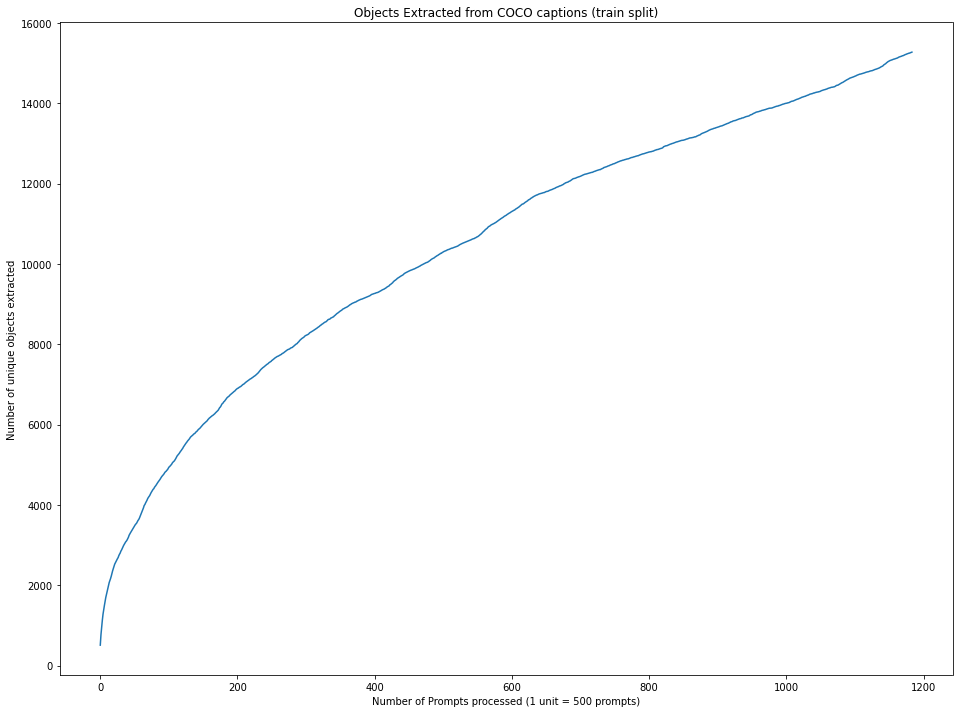

In [10]:
plt.figure(figsize=(16,12))
plt.plot(train_objects_file['num_objects'])
plt.xlabel(f'Number of Prompts processed (1 unit = {NUM_PROMPTS_INFO_DISPLAY} prompts)')
plt.ylabel('Number of unique objects extracted')
plt.title('Objects Extracted from COCO captions (train split)')
plt.show()

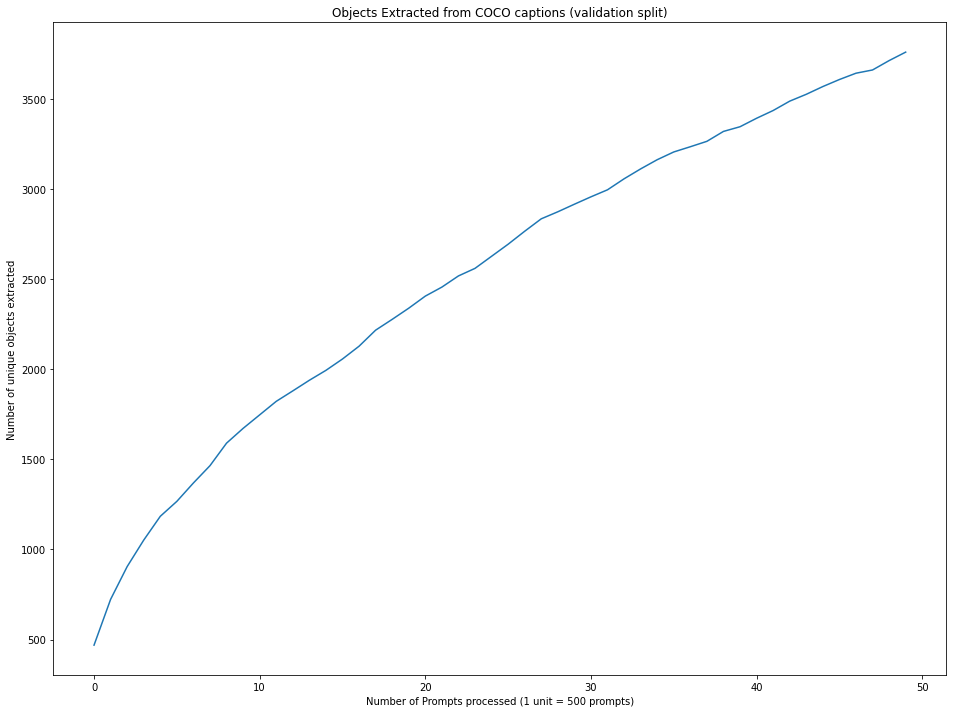

In [11]:
plt.figure(figsize=(16,12))
plt.plot(val_objects_file['num_objects'])
plt.xlabel(f'Number of Prompts processed (1 unit = {NUM_PROMPTS_INFO_DISPLAY} prompts)')
plt.ylabel('Number of unique objects extracted')
plt.title('Objects Extracted from COCO captions (validation split)')
plt.show()